In [1]:
import numpy as np
from scipy.linalg import solve_discrete_are
from scipy.optimize import minimize
from control.matlab import ss, c2d, dlqr,ss2tf, tf, step
import control 
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

import os
from numpy import array
import random
import numpy as geek

import datetime
import math
import gym
from gym import spaces, logger
from gym.utils import seeding

import torch
import torch.nn as nn
import torch.optim as optim
import cvxpy as cp
from scipy.io import savemat

In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import gym
import matplotlib.pyplot as plt
import random
from collections import OrderedDict
from copy import copy
import argparse
import os
from torch.utils.tensorboard import SummaryWriter
import sys
from scipy.integrate import odeint
import time

In [3]:
class CartPoleEnv(gym.Env):
    """
    Description: A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The
    pendulum starts upright, and the goal is to prevent it from falling over by increasing and reducing the cart's
    velocity.

    Source:
        This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson

    Observation:
        Type: Box(4)
        Num	Observation                 Min         Max
        0	Cart Position             -2.4            2.4
        1	Cart Velocity             -Inf            Inf
        2	Pole Angle                 -180 deg       180 deg
        3	Pole Velocity At Tip      -Inf            Inf

    Actions:
        Type: Discrete(3)
        Num	Action
        0	Push cart to the left
        1   No force
        2	Push cart to the right

        Note: The amount the velocity that is reduced or increased is not fixed; it depends on the angle the pole is
        pointing. This is because the center of gravity of the pole increases the amount of energy needed to move the
        cart underneath it

    Reward:
        Reward is based on the difference between the current state and the target

    Starting State:
        All observations are assigned a uniform random value in [-0.05..0.05]
        Can be set to any angle between -180 to 180 degrees using the reset() function

    Episode Termination:
        Pole Angle is more than 12 degrees 
        Cart Position is more than 2.4 (center of the cart reaches the edge of the display)
        Episode length is greater than 200
        Solved Requirements
        Considered solved when the average reward is greater than or equal to 195.0 over 100 consecutive trials.
    """

    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second': 50
    }

    def __init__(self):
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = (self.masspole + self.masscart)
        self.length = 0.5  # actually half the pole's length
        self.polemass_length = (self.masspole * self.length)
        #self.force_mag = 10.0
        self.tau = 0.01  # seconds between state updates 0.02
        self.kinematics_integrator = 'euler'

        #spring related
        #self.spring_stiffness = 40.0  #the ability of a spring to resist a force
        #self.spring_damping = 0.05  #a dimensionless measure describing how oscillations in a system decay after a disturbance

        # Angle at which to fail the episode
        self.theta_threshold_radians =  45 * 2 * math.pi / 360    #12
        self.x_threshold = 2.4  #2.4

        # Angle limit set to 2 * theta_threshold_radians so failing observation is still within bounds
        high = np.array([
            self.x_threshold * 2,
            np.finfo(np.float32).max,
            self.theta_threshold_radians * 2,
            np.finfo(np.float32).max])

        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

        self.seed()
        self.viewer = None
        self.state = None

        x_coefficient = 1.
        theta_coefficient = 1.
        self.reference = (0., 0., 0., 0.)
        self.max_deviation = np.array([self.x_threshold, 1, self.theta_threshold_radians, 1]) \
                             - np.array(self.reference)
        self.Q = np.array([
            [x_coefficient, 0., 0., 0.],
            [0., 0, 0., 0.],
            [0., 0., theta_coefficient, 0.],
            [0., 0., 0., 0]
        ])
        #self.Q = geek.ones([4, 4], dtype = int) 
        self.max_reward = x_coefficient + theta_coefficient
        self.counter = 0
        #self.counter_max = 20000  #200

        self.steps_beyond_done = None

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        #assert self.action_space.contains(action), "%r (%s) invalid" % (action, type(action))
        state = self.state
        self.counter += 1
        x, x_dot, theta, theta_dot = state

        # Calculate spring force
        #spring_force = -self.spring_stiffness * theta - self.spring_damping * theta_dot


        """
        while theta < -np.pi or theta > np.pi:
            if theta > np.pi:
                theta = theta - 2 * np.pi
            if theta < -np.pi:
                theta = 2 * np.pi + theta
        """
        # force = self.force_mag if action == 1 else -self.force_mag
        #if action == 2:
            #force = self.force_mag
        #elif action == 0:
            #force = -self.force_mag
        #else:
            #force = 0.
        
        force = action
            
        costheta = math.cos(theta)
        sintheta = math.sin(theta)
        temp = (force + self.polemass_length * theta_dot**2 * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (
            self.length * (4.0 / 3.0 - self.masspole * costheta**2 / self.total_mass))
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass
        if self.kinematics_integrator == 'euler':
            x = x + self.tau * x_dot
            x_dot = x_dot + self.tau * xacc
            theta = theta + self.tau * theta_dot
            theta_dot = theta_dot + self.tau * thetaacc
        else:  # semi-implicit euler
            x_dot = x_dot + self.tau * xacc
            x = x + self.tau * x_dot
            theta_dot = theta_dot + self.tau * thetaacc
            theta = theta + self.tau * theta_dot
        theta_fixed = np.arcsin(np.sin(theta))
        if np.cos(theta) < 0:
            theta = - np.pi - theta_fixed if theta_fixed < 0 else np.pi - theta_fixed
        self.state = (x, x_dot, theta, theta_dot)
        
        #termination
        done = x < -self.x_threshold \
               or x > self.x_threshold \
               or theta < -self.theta_threshold_radians \
               or theta > self.theta_threshold_radians 
               #or self.counter >= self.counter_max
        done = bool(done)

        if not done:
            #reward = 1.0
            state_difference = np.asarray(self.state) - np.asarray(self.reference)
            state_difference = np.divide(state_difference, self.max_deviation)
            reward = self.max_reward - 1 * np.matmul(np.matmul(state_difference, self.Q),
                                                     np.transpose(state_difference))
        elif self.steps_beyond_done is None:
            # Pole just fell!
            self.steps_beyond_done = 0
            #reward = 1.0
            state_difference = np.asarray(self.state) - np.asarray(self.reference)
            state_difference = np.divide(state_difference, self.max_deviation)
            #reward = self.max_reward - 1 * np.matmul(np.matmul(state_difference, self.Q),
                                                     #np.transpose(state_difference)) - \
                                                    #(self.counter_max - self.counter) * 0 - self.counter_max
            reward = self.max_reward - 1 * np.matmul(np.matmul(state_difference, self.Q),
                                                     np.transpose(state_difference))
        else:
            if self.steps_beyond_done == 0:
                logger.warn(
                    "You are calling 'step()' even though this environment has already returned done = True. You "
                    "should always call 'reset()' once you receive 'done = True' -- any further steps are undefined "
                    "behavior.")
            self.steps_beyond_done += 1
            reward = 0.0

        return np.array(self.state), reward, done, {}

    def reset(self, initial_x = 0.0, initial_angle=None, duration=None):
        
        self.state = self.np_random.uniform(low=-0.05, high=0.05, size=(4,)) #0.05
        self.state[0] = random.uniform(-0.3, 0.3)
        #self.state[1] = random.random()
        self.state[2] = random.uniform(-0.42, 0.42)
        #self.state[3] = random.random()
        
        #self.state[0] = initial_x
        
        #if initial_angle is not None:
            #self.state[2] = initial_angle * np.pi / 180
        #if duration is not None:
            #self.counter_max = duration
        #else:
            #self.counter_max = 500  #200
        self.steps_beyond_done = None
        #self.counter = 0
        
        return np.array(self.state)
    
    def reset_for_given_state(self, given_state, initial_angle=None, duration=None):
        
        self.state = given_state
        

    
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print('Error: Creating directory. ' + directory)

def down_scale(input_arr, scale, normalized=False):
    normalized_val = 255. if normalized is True else 1.
    if len(input_arr.shape) == 3:
        (input_size_x, input_size_y, num_channels) = input_arr.shape
    else:
        (input_size_x, input_size_y) = input_arr.shape
        num_channels = 1
    assert input_size_x % scale == 0, "Scaling issue: Output X is not an integer"
    assert input_size_y % scale == 0, "Scaling issue: Output Y is not an integer"
    output_size_x = input_size_x // scale
    output_size_y = input_size_y // scale
    return input_arr.reshape((output_size_x, scale,
                              output_size_y, scale, num_channels)).mean(3).mean(1) / normalized_val




In [4]:
def gaussian_init_(n_units, std=1):    
    sampler = torch.distributions.Normal(torch.Tensor([0]), torch.Tensor([std/n_units]))
    Omega = sampler.sample((n_units, n_units))[..., 0]  
    return Omega

In [5]:
class data_collecter():
    def __init__(self) -> None:
        np.random.seed(2022)
        random.seed(2022)
        
        self.env = CartPoleEnv()
        self.Nstates = 4 #self.env.Nstates
            
        self.umax = np.array([10]) #self.env.umax
        self.umin = np.array([-10]) #self.env.umin
        self.udim = 1
        
    def collect_koopman_data(self,traj_num,steps,mode="train"):
        train_data = np.empty((steps+1,traj_num,self.Nstates+self.udim))
                
        for traj_i in range(traj_num):
            s0 = self.env.reset()
            u10 = np.random.uniform(self.umin, self.umax)                
            train_data[0,traj_i,:]=np.concatenate([u10.reshape(-1),s0.reshape(-1)],axis=0).reshape(-1)
            
            for i in range(1,steps+1):                   
                s0,r,done,_ = self.env.step(u10)
                u10 = np.random.uniform(self.umin, self.umax)
                train_data[i,traj_i,:]=np.concatenate([u10.reshape(-1),s0.reshape(-1)],axis=0).reshape(-1)
        return train_data

In [6]:
class Network(nn.Module):
    def __init__(self,encode_layers,Nkoopman,u_dim):
        super(Network,self).__init__()
        Layers = OrderedDict()
        for layer_i in range(len(encode_layers)-1):
            Layers["linear_{}".format(layer_i)] = nn.Linear(encode_layers[layer_i],encode_layers[layer_i+1])
            if layer_i != len(encode_layers)-2:
                Layers["relu_{}".format(layer_i)] = nn.ReLU()
        self.encode_net = nn.Sequential(Layers)
        self.Nkoopman = Nkoopman
        self.u_dim = u_dim
        self.lA = nn.Linear(Nkoopman,Nkoopman,bias=False)
        self.lA.weight.data = gaussian_init_(Nkoopman, std=1)
        U, _, V = torch.svd(self.lA.weight.data)
        self.lA.weight.data = torch.mm(U, V.t()) * 0.9
        self.lB = nn.Linear(u_dim,Nkoopman,bias=False)

    def encode_only(self,x):
        return self.encode_net(x)

    def encode(self,x):
        return torch.cat([x,self.encode_net(x)],axis=-1)
    
    def forward(self,x,u):
        return self.lA(x)+self.lB(u)

In [7]:
Data_collect = data_collecter()
udim = Data_collect.udim
Nstate = Data_collect.Nstates
layer_depth = 3
layer_width = 128
dicts = torch.load("logDirU.pth")
state_dict = dicts["model"]
layer = dicts["layer"]
NKoopman = layer[-1]+Nstate
net = Network(layer,NKoopman,udim)  
net.load_state_dict(state_dict)
device = torch.device("cpu")
net.cpu()
net.double()



C:\ProgramData\Anaconda3\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Network(
  (encode_net): Sequential(
    (linear_0): Linear(in_features=4, out_features=128, bias=True)
    (relu_0): ReLU()
    (linear_1): Linear(in_features=128, out_features=128, bias=True)
    (relu_1): ReLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
    (relu_2): ReLU()
    (linear_3): Linear(in_features=128, out_features=20, bias=True)
  )
  (lA): Linear(in_features=24, out_features=24, bias=False)
  (lB): Linear(in_features=1, out_features=24, bias=False)
)

In [8]:
import time
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la

simTime = 3.0
dt = 0.1

# x[k+1] = Ax[k] + Bu[k]
# A = np.matrix([[1, 1.0], [0, 1]])
# B = np.matrix([0.0, 1]).T
# Q = np.matrix([[1.0, 0.0], [0.0, 0.0]])
# R = np.matrix([[1.0]])
Kopt = None


def process(x, u):
    x = A * x + B * u
    return (x)


def solve_DARE_with_iteration(A, B, Q, R):
    """
    solve a discrete time_Algebraic Riccati equation (DARE)
    """
    X = Q
    maxiter = 150
    eps = 0.01

    for i in range(maxiter):
        Xn = A.T * X * A - A.T * X * B * \
            la.inv(R + B.T * X * B) * B.T * X * A + Q
        if (abs(Xn - X)).max() < eps:
            X = Xn
            break
        X = Xn

    return Xn


def dlqr_with_iteration(Ad, Bd, Q, R):
    """Solve the discrete time lqr controller.
    x[k+1] = Ad x[k] + Bd u[k]
    cost = sum x[k].T*Q*x[k] + u[k].T*R*u[k]
    # ref Bertsekas, p.151
    """

    # first, try to solve the ricatti equation
    X = solve_DARE_with_iteration(Ad, Bd, Q, R)

    # compute the LQR gain
    K = np.matrix(la.inv(Bd.T * X * Bd + R) * (Bd.T * X * Ad))

    return K


def dlqr_with_arimoto_potter(Ad, Bd, Q, R):
    """Solve the discrete time lqr controller.
    x[k+1] = Ad x[k] + Bd u[k]
    cost = sum x[k].T*Q*x[k] + u[k].T*R*u[k]
    # ref Bertsekas, p.151
    """

    n = len(Bd)

    # continuous
    Ac = (Ad - np.eye(n)) / dt
    Bc = Bd / dt

    # Hamiltonian
    Ham = np.vstack(
        (np.hstack((Ac, - Bc * la.inv(R) * Bc.T)),
         np.hstack((-Q, -Ac.T))))

    eigVals, eigVecs = la.eig(Ham)

    V1 = None
    V2 = None

    for i in range(2 * n):
        if eigVals[i].real < 0:
            if V1 is None:
                V1 = eigVecs[0:n, i]
                V2 = eigVecs[n:2 * n, i]
            else:
                V1 = np.vstack((V1, eigVecs[0:n, i]))
                V2 = np.vstack((V2, eigVecs[n:2 * n, i]))
    V1 = np.matrix(V1.T)
    V2 = np.matrix(V2.T)

    P = (V2 * la.inv(V1)).real

    K = la.inv(R) * Bc.T * P

    return K

def lqr_regulator_k(A,B,Q,R):
    Kopt = dlqr_with_arimoto_potter(A, B, Q, R)
    return Kopt
    
def lqr_regulator(x):
    global Kopt
    if Kopt is None:
        start = time.time()
        #  Kopt = dlqr_with_iteration(A, B, np.eye(2), np.eye(1))
        Kopt = dlqr_with_arimoto_potter(A, B, np.eye(2), np.eye(1))

        elapsed_time = time.time() - start
        print("elapsed_time:{0}".format(elapsed_time) + "[sec]")

    u = -Kopt * x
    return u


def lqr_ref_tracking(x, xref, uref):
    global Kopt
    if Kopt is None:
        #  start = time.time()
        #  Kopt = dlqr_with_iteration(A, B, np.eye(2), np.eye(1))
        Kopt = dlqr_with_arimoto_potter(A, B, Q, R)

        #  elapsed_time = time.time() - start
        #  print("elapsed_time:{0}".format(elapsed_time) + "[sec]")

    u = -uref - Kopt * (x - xref)

    return u


def main_regulator():
    t = 0.0

    x = np.matrix([3, 1]).T
    u = np.matrix([0])

    time_history = [0.0]
    x1_history = [x[0, 0]]
    x2_history = [x[1, 0]]
    u_history = [0.0]

    while t <= simTime:
        u = lqr_regulator(x)

        u0 = float(u[0, 0])
        x = process(x, u0)

        x1_history.append(x[0, 0])
        x2_history.append(x[1, 0])

        u_history.append(u0)
        time_history.append(t)
        t += dt

    plt.plot(time_history, u_history, "-r", label="input")
    plt.plot(time_history, x1_history, "-b", label="x1")
    plt.plot(time_history, x2_history, "-g", label="x2")
    plt.grid(True)
    plt.xlim([0, simTime])
    plt.title("LQR Regulator")
    plt.legend()
    plt.show()


def main_reference_tracking():
    t = 0.0

    x = np.matrix([3, 1]).T
    u = np.matrix([0])
    xref = np.matrix([1, 0]).T
    uref = 0.0

    time_history = [0.0]
    x1_history = [x[0, 0]]
    x2_history = [x[1, 0]]
    u_history = [0.0]

    while t <= simTime:
        u = lqr_ref_tracking(x, xref, uref)

        u0 = float(u[0, 0])
        x = process(x, u0)

        x1_history.append(x[0, 0])
        x2_history.append(x[1, 0])

        u_history.append(u0)
        time_history.append(t)
        t += dt

    plt.plot(time_history, u_history, "-r", label="input")
    plt.plot(time_history, x1_history, "-b", label="x1")
    plt.plot(time_history, x2_history, "-g", label="x2")
    xref0_h = [xref[0, 0] for i in range(len(time_history))]
    xref1_h = [xref[1, 0] for i in range(len(time_history))]
    plt.plot(time_history, xref0_h, "--b", label="target x1")
    plt.plot(time_history, xref1_h, "--g", label="target x2")

    plt.grid(True)
    plt.xlim([0, simTime])
    plt.title("LQR Tracking")
    plt.legend()
    plt.show()




In [9]:
#control results

In [9]:
def Psi_o(s,net): # Evaluates basis functions Ψ(s(t_k))
    psi = np.zeros([NKoopman,1])
    ds = net.encode(torch.DoubleTensor(s)).detach().cpu().numpy()
    psi[:NKoopman,0] = ds
    return psi

def Prepare_LQR(env_name):
    Nstates = Data_collect.Nstates
    x_ref = np.zeros(Nstates)
    if env_name.startswith("CartPole"):
        #Q = np.zeros((NKoopman,NKoopman))
        Q = np.identity(NKoopman)
        Q[0,0] = 1.0        
        Q[1,1] = 1.0
        Q[2,2] = 1.0
        Q[3,3] = 0.01
        R = 0.001*np.eye(1)
        reset_state=  [0.0,0.0,0.0,0]
    
    Q = np.matrix(Q)
    R = np.matrix(R)
    return Q,R,reset_state,x_ref


<ipython-input-3-236d1ef0fb37>:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  logger.warn(


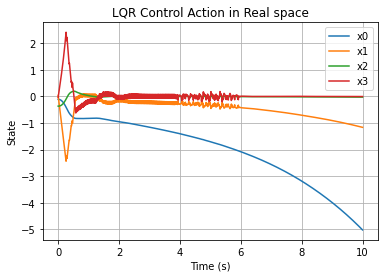

In [10]:
Ad = state_dict['lA.weight'].cpu().numpy()
Bd = state_dict['lB.weight'].cpu().numpy()
env = Data_collect.env
Nstates = Data_collect.Nstates
env_name = 'CartPole'
env.reset()

Ad = np.matrix(Ad)
Bd = np.matrix(Bd)
Q,R,reset_state,x_ref = Prepare_LQR(env_name)
Kopt = lqr_regulator_k(Ad,Bd,Q,R)
observation_list = []
observation = env.reset()
x0 = np.matrix(Psi_o(observation,net))
x_ref_lift = Psi_o(x_ref,net)
observation_list.append(x0[:Nstates].reshape(-1,1))
umax = 10
umin = -10
# print(Kopt)
u_list = []
steps = 1000
# umax = 100
for i in range(steps):
    #print('1')
    # env.render()
    u = -Kopt*(x0-x_ref_lift) #in lifted space
    
    #u1 = max(u_latent_max[0], min(u_latent_min[0], u[0,0]))
    
    
    
    # u = max(-umax,min(umax,u[0,0]))
    # print(type(u[0,0]),type(u))
    #gu = net.bilinear_net(torch.DoubleTensor(u))
    ureal = u
    #print(ureal)
    ureal1 = ureal[0,0]
    
    #define a range for action
    if(ureal[0,0] > umax):
        ureal1 = umax
    elif(ureal[0,0] < umin):
        ureal1 = umin
        
    
    observation, reward, done, info = env.step(ureal1) #real space
    x0 = np.matrix(Psi_o(observation,net)) #lifted space
    # x0 = Ad*x0+Bd*u
    #observation_list.append(x0[:Nstates].reshape(-1,1))
    observation_list.append(observation.reshape(-1,1))
    u_list.append(ureal1)
    # time.sleep(0.1)

observations = np.concatenate(observation_list,axis=1)
u_list = np.array(u_list).reshape(-1)
time_history = np.arange(steps+1)*0.01
for i in range(Nstates):
    plt.plot(time_history, observations[i,:].reshape(-1,1), label="x{}".format(i))
    
plt.grid(True)
plt.title("LQR Control Action in Real space")
plt.xlabel('Time (s)')
plt.ylabel('State')
plt.legend()
plt.show()

In [11]:
Ad = state_dict['lA.weight'].cpu().numpy()
Bd = state_dict['lB.weight'].cpu().numpy()
Data_collect = data_collecter()
env = CartPoleEnv()
Nstates = Data_collect.Nstates
env_name = 'CartPole'
env.reset()
#import lqr
rician_factor = 10
M=1

Ad = np.matrix(Ad)
Bd = np.matrix(Bd)
Q,R,reset_state,x_ref = Prepare_LQR(env_name)

Kopt = lqr_regulator_k(Ad,Bd,Q,R)
#Kopt = lqr_abanoub(Ad,Bd,Q,R)

observation_list = []
observation = env.reset()

x0 = np.matrix(Psi_o(observation,net))
x_ref_lift = Psi_o(x_ref,net)
observation_list.append(x0[:Nstates].reshape(-1,1))
umax = 10
umin = -10

C:\ProgramData\Anaconda3\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [12]:
error_threshold = 0.5
transmit_power = 3.2e-3 #Watt for -15dBm , 3.01dBm = 0.002 W
sense_power = 1e-5 #1 dbm = 0.00102 watt    -20dBm = 100mW
total_battery_power = 1 # 30 dbm = 1 watt total power per hour

intercept = 0.22218
coef = [0, -1.79677644e+00, -1.71158171e-02,  3.87043146e+00, 8.73438966e-02,  1.35147245e-04]

def calculate_E(state, aoi, intercept, coefficients):
    error = intercept + (coef[1]*state) + (coef[2]*aoi) + (coef[3]*state*state) + (coef[5]*aoi*aoi)+ (coef[4]*state*aoi)            
    return error

In [13]:
def optimal_a(battery_power, p,sense_power, V, Q_a, beta,state, error_threshold, h, h_threshold):
   
    
    a = cp.Variable(nonneg=True)
    gamma = cp.Variable(nonneg=True)
    
    intercept = 0.074
    coef = [0, -0.735, 9.413e-05,  1.4918, 1.77e-02, 0]

    constant = intercept + (coef[1]*state) + (coef[2]*(1+beta)) + (coef[3]*state*state) + (coef[5]*(1+ (2*beta) + (beta*beta))) + (coef[4]*state*(1+beta))
    c1 = -1 * ((coef[2]*beta) + (2*coef[5]*beta*(1+beta)) + (coef[4]*state*beta)) 
    c2 = coef[5]*beta*beta
    
    # Create constraints.
    constraints = [(constant + (c1*a) + (c2*a**2)) <= error_threshold,
                  battery_power >= a*p + sense_power,
                  a* h >= h_threshold,
                  0 <= a, 
                  a <= 1.0,
                  gamma <= 1.0,
                   0 <= gamma,
                  a <= gamma]
    
    obj = cp.Minimize((V*gamma) + (Q_a* a) - (Q_a* gamma) - (battery_power*(a*p +sense_power )) + (beta*(1-a)))
    
    #p> pmax
    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.ECOS, abstol=1e-9, reltol=1e-9)
    
    #print("c2:", c2)
    #print("state:", state)
    #print("beta:", beta)
    #print("battery_power:", battery_power)
    #print("p:", p)
    #print("c1:", c1)
    #print("constant:", constant)
    #print("a:", a.value)
    #print("gamma:", gamma.value)
    #print("Problem status:", prob.status)
    #print('------')
    
    if prob.status == 'infeasible':
        return prob.status, 0, 0
    elif a.value is None:
        return prob.status,1, 1
    elif gamma.value is None:
        return prob.status,1, 1
    else:
        return prob.status,a.value, gamma.value

In [14]:
def get_channel_matrix(rician_factor, M):
    
    ang = 2 * np.pi * np.random.rand()

    # Compute phase shift
    phi = -(np.arange(M) * np.pi * np.sin(ang))

    # LOS Component
    h_los = np.sqrt(rician_factor / (1 + rician_factor)) * np.exp(1j * np.pi / 4) * np.exp(1j * phi)
    #h_los = np.sqrt(rician_factor / (1 + rician_factor)) *  np.eye(M)

    # NLOS Component (Rayleigh fading)
    h_nlos = np.sqrt(1 / (2 * (1 + rician_factor))) * (np.random.randn(M) + 1j * np.random.randn(M))
    
    
    #################
    #M*M matrix
    # Phase shift for LOS path
    #phi = -(np.arange(M) * np.pi * np.sin(ang))
    
    # Line-of-Sight (LOS) Component (Rank-1 matrix)
    #h_los = np.sqrt(rician_factor / (1 + rician_factor)) * np.exp(1j * np.pi / 4) * np.exp(1j * phi[:, None])
    #h_los = np.sqrt(rician_factor / (1 + rician_factor))* np.eye(M)

    # Non-Line-of-Sight (NLOS) Component (Rayleigh fading, full MxM)
    #h_nlos = np.sqrt(1 / (2 * (1 + rician_factor))) * (np.random.randn(M, M) + 1j * np.random.randn(M, M))
    
    
    

    # Total channel response
    hf = h_los + h_nlos
    
    return hf

In [15]:
def calculate_controls(u_pred_count, net, latent_x, x_ref, Kopt, umax, umin, x_current):
    
    u_dim = 1
    no_of_controls = u_pred_count
    u_array = np.zeros((no_of_controls,u_dim))
    x0 = latent_x
    x_ref_lift = x_ref
     
    
    for i in range(no_of_controls):
        
        u = -Kopt*(x0-x_ref_lift) #in lifted space
      
        ureal = u
        #define a range for action
        ureal1 = ureal[0,0]
    
        if(ureal[0,0] > umax):
            ureal1 = umax
        elif(ureal[0,0] < umin):
            ureal1 = umin
        
   
    
        next_state = net.forward(x_current,torch.DoubleTensor(np.array([ureal1]).reshape(-1)))
    
        #next_state = net.forward(x_current,torch.DoubleTensor(u))
    
        observation, reward, done, info = env.step(ureal1) #real space
        
                  
        #store u value
        u_array[i,0] = ureal1
       
        
        x0 = next_state.reshape(-1,1).detach().numpy()
        x_current = next_state.reshape(-1)
        
        
    return u_array   

In [17]:
def execute_main(snr, transmit_power, episode, steps, no_control_predictions, h_threshold, error_threshold, Kopt, x_ref, net):
    
    episode = episode
    steps = steps
    snr = snr
    dimension = 4
    latent_dimension = 20
    action_dimention = 1
    starting_states = 1
    prediction_steps = 20
    V = 10
    error_threshold = error_threshold
    #h_threshold = 0.12
    h_threshold_dl = 0.12
    rician_factor= 10
    M=1    
    
    transmit_power = transmit_power #Watt for -15dBm , 3.01dBm = 0.002 W
    sense_power = 1e-5 #1 dbm = 0.00102 watt    -20dBm = 100mW
    total_battery_power = 1 #watt
    
    u_pred_count = prediction_steps #Number of control action predictions

    battery_power = np.zeros((episode,steps+1))
    Q_a = np.zeros((episode,steps+1))

    beta = np.zeros((episode,steps+1))
    
    
    env = CartPoleEnv()
    Nstates = dimension
    env_name = 'CartPole'
    env.reset()
    observation = env.reset()

    x0 = np.matrix(Psi_o(observation,net))
    x_ref_lift = Psi_o(x_ref,net)

    umax = 10
    umin = -10

    Q_real = np.identity(dimension)
    Q_real[0,0] = 1     
    Q_real[1,1] = 1
    Q_real[2,2] = 1
    Q_real[3,3] = 0.1
    
    R = 0.001*np.eye(action_dimention)

    x_value = np.zeros((episode,steps,dimension))
    x_pred_value = np.zeros((episode,steps,dimension))

    z_value = np.zeros((episode,steps,latent_dimension))
    z_pred_value = np.zeros((episode,steps,latent_dimension))

    x_error = np.zeros((episode,steps,dimension))
    z_error = np.zeros((episode,steps,latent_dimension))

    stability_error = np.zeros((episode,steps))
    control_error = np.zeros((episode,steps))
    total_error = np.zeros((episode,steps))

    u_array = np.zeros((episode,steps,action_dimention))
    

    z_ref = Psi_o(x_ref,net)

    a_array = np.zeros((episode,steps))
    g_array = np.zeros((episode,steps))


    observation = env.reset()
    #observation = exact_start
    x_value[0,0,:] = observation

    x_latent = np.matrix(Psi_o(observation,net))
     
    
    for i in range(episode):
        
        #state = np.array(x_value[0,0,:])                 
        #env.reset_for_given_state(state)
        state = env.reset()
        x_value[i,0,:] = state
    
        observation = state
    
    
        x0 = np.matrix(Psi_o(observation,net))    
        x_current = net.encode(torch.DoubleTensor(observation))
    
        beta[i,0] = 1
    
        required_power = sense_power + transmit_power
        battery_power[i,0] = total_battery_power
        Q_a[i,0] = 1
      
        counter = 0
    
        last_send_state = state
        
        succ_ca = ((u_pred_count,action_dimention))
        ca_counter = 0 #count not received packets in ca link
            
        for j in range(steps):
        
            
            counter = counter +1
            #call control action computation method
            predicted_array = calculate_controls(u_pred_count, net, x0, x_ref_lift, Kopt, umax, umin, x_current)
        
            ureal1 = predicted_array[0,0]
            
            next_state = net.forward(x_current,torch.DoubleTensor(np.array([ureal1]).reshape(-1)))
            
            
        
            if j == 0:
                succ_ca = predicted_array
            else:
                h =get_channel_matrix(rician_factor,M)
                norm = np.linalg.norm(h)
                h_square = norm*norm
                
                if h_square >= h_threshold_dl: #successfully transmit
                    succ_ca = predicted_array
                    ca_counter = 0
                else:
                    ca_counter = 1 + ca_counter
                    
                    if ca_counter > (prediction_steps-1):
                        ca_counter = prediction_steps -1
                    
            control_action1 = succ_ca[ca_counter, 0]
            
            
            
            u_array[i,j,:] = control_action1
            
            observation,reward, done, info = env.step(control_action1) #real space    
            x_value[i,j,:] = observation 
        
            #real z value for store
            z_store = np.matrix(Psi_o(observation,net)) #lifted space
            z_value[i,j,:] = z_store[Nstates:].reshape(-1)
        
            #solve minimization problem
            state_norm = np.linalg.norm(last_send_state)
            error = calculate_E(state_norm, beta[i,j], intercept, coef)
        
            h =get_channel_matrix(rician_factor,M)
            norm = np.linalg.norm(h)
            h_square = norm*norm
        
            if battery_power[i,j] < (transmit_power+sense_power):
                print('battery power over')
                a = 0
                g = 0
                beta[i,j+1] = 1+beta[i, j]
                x0 = next_state.reshape(-1,1).detach().numpy()
                x_current = next_state.reshape(-1)
            
                if (battery_power[i,j] - sense_power) < 0 :
                    battery_power[i,j] = 0
                else:
                    battery_power[i,j+1] = battery_power[i,j] - sense_power
                
                a_array[i,j] = a
                g_array[i,j] = g
                
            elif h_square < h_threshold:
                a = 0
                g = 0
            
                a_array[i,j] = a
                g_array[i,j] = g
            
                battery_power[i,j+1] = battery_power[i,j] - sense_power
                beta[i,j+1] = 1+beta[i, j]
                x0 = next_state.reshape(-1,1).detach().numpy()
                x_current = next_state.reshape(-1)
            
            else:
            
                feasible,a,g = optimal_a(battery_power[i,j], transmit_power,sense_power, V, Q_a[i,j], beta[i,j], state_norm, error_threshold, h_square, h_threshold)       
        
                #get value for a #due to error threshold
                if feasible == 'infeasible':
                    print('Infeasible point occured')
                    a = 1
                    gamma = 1
                
                    a_array[i,j] = a
                    g_array[i,j] = g
                else:
                    a = round(float(a), 3)            
                    g = round(float(g), 3)
                
                    a_array[i,j] = a
                    g_array[i,j] = g
        
                if a >= 0.5:           #transmission occur
                    beta[i,j+1] = 1
                    x0 = np.matrix(Psi_o(observation,net)) #lifted space
                    x_current = net.encode(torch.DoubleTensor(observation))
                    battery_power[i,j+1] = battery_power[i,j] - required_power
                
                    last_send_state = observation
                       
            
                else:
                    beta[i,j+1] = 1+beta[i, j]
                    x0 = next_state.reshape(-1,1).detach().numpy()
                    x_current = next_state.reshape(-1)
                    battery_power[i,j+1] = battery_power[i,j] - sense_power
            
            
            
            #e_value = calculate_E(state_norm, beta[i,j+1], intercept, coef)
            Q_a[i,j+1] = np.max(Q_a[i,j]- g_array[i,j], 0) + a_array[i,j]
            
            x_pred_value[i,j,:] = x0[:Nstates].reshape(-1) ##########################
            z_pred_value[i,j,:] = x0[Nstates:].reshape(-1) ############################
                        
        
            #stability error
            #difference =  next_state.reshape(-1,1).detach().numpy() - z_ref  #z-z0
            #stability_d = difference.T * Q * difference
            #stability_error[i,j] = stability_d
        
            difference =  observation  #z-z0
            stability_d = np.dot(np.dot(observation, Q_real), observation)
            stability_error[i,j] = stability_d
            
            u_cost = np.dot(np.dot(control_action1, R), control_action1)
            control_error[i,j] = u_cost
            total_error[i,j] = stability_d + u_cost
                                         
    #save data
    mdic = {"x_val": x_value, "z_val": z_value,"x_pred_value":x_pred_value,"z_pred_value":z_pred_value, 'stability_error': stability_error, 'u_array':u_array, 'control_error':control_error,'total_error':total_error, 'Q_a':Q_a, 'a':a_array, 'g':g_array, 'bat_power':battery_power, 'beta':beta }
    savemat(f"matlab_U_outage{h_threshold}_SNR{snr}_epi{episode}_V{V}.mat", mdic)
    print(h_threshold)
    
    #time_history = np.arange(steps)*0.01
    ##for i in range(Nstates):
    #plt.plot(time_history, total_error[0,:].reshape(-1,1), label="x{}".format(i))
    
    #plt.grid(True)
    #plt.title("LQR Control Action in Real space")
    #plt.xlabel('Time (s)')
    #plt.ylabel('State')
    #plt.legend()
    #plt.show()
    

In [17]:
#outage values 1e-4, 1e-3 , 1e-2, 1e-1, 1, 10
s_values = [0.045, 0.12, 0.25, 0.51]

In [18]:
#calculate for different snr
#sensor_power = 1e-5 #1 dbm = 0.00102 watt    -20dBm = 100mW 
episode = 100
steps = 1000
no_control_predictions = 10 
h_threshold = 0.12 
error_threshold = 0.7 
Nw = 3.8e-8

for snr in range(25,26,5):
    
    snr_linear = 10 ** (snr / 10)    #in watt
    p = snr_linear * Nw / h_threshold   #in watt
    transmit_power = p
    
    execute_main(snr, transmit_power, episode, steps, no_control_predictions, h_threshold, error_threshold, Kopt, x_ref, net)

<ipython-input-3-236d1ef0fb37>:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  logger.warn(


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


C:\ProgramData\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured
Infeasible point occured


In [ ]:
#calculate for different outage
episode = 20
steps = 1000
no_control_predictions = 10 
h_threshold = 0.12 
error_threshold = 0.3 
Nw = 3.8e-8
snr = 20

for h_val in [0.12]:
    
    snr_linear = 10 ** (snr / 10)    #in watt
    p = snr_linear * Nw / h_val   #in watt
    transmit_power = p
    
    execute_main(snr, transmit_power, episode, steps, no_control_predictions, h_val, error_threshold, Kopt, x_ref, net)

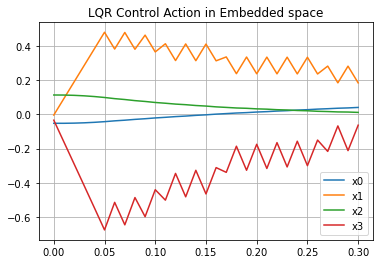

In [12]:
#control action applied on lifted space
#planning
Ad = state_dict['lA.weight'].cpu().numpy()
Bd = state_dict['lB.weight'].cpu().numpy()
env = Data_collect.env
Nstates = Data_collect.Nstates
env_name = 'CartPole'
env.reset()
import lqr
import time
Ad = np.matrix(Ad)
Bd = np.matrix(Bd)
Q,R,reset_state,x_ref = Prepare_LQR(env_name)
Kopt = lqr_regulator_k(Ad,Bd,Q,R)
observation_list = []
observation = env.reset(reset_state)
x0 = np.matrix(Psi_o(observation,net))
x_ref_lift = Psi_o(x_ref,net)
observation_list.append(x0[:Nstates].reshape(-1,1))
# print(Kopt)
u_list = []
steps = 30
# umax = 100
x_current = net.encode(torch.DoubleTensor(observation))

for i in range(steps):
    # env.render()
    u = -Kopt*(x0-x_ref_lift) #in lifted space
    # u = max(-umax,min(umax,u[0,0]))
    # print(type(u[0,0]),type(u))
    #gu = net.bilinear_net(torch.DoubleTensor(u))
    
    ureal = u
    #define a range for action
    ureal1 = ureal[0,0]
    
    if(ureal[0,0] > umax):
        ureal1 = umax
    elif(ureal[0,0] < umin):
        ureal1 = umin
        
   
    
    next_state = net.forward(x_current,torch.DoubleTensor(np.array([ureal1]).reshape(-1)))
    
    #next_state = net.forward(x_current,torch.DoubleTensor(u))
    
    observation, reward, done, info = env.step(ureal1) #real space
    #x0 = np.matrix(Psi_o(observation,net)) #lifted space
    # x0 = Ad*x0+Bd*u
    x0 = next_state.reshape(-1,1).detach().numpy()
    x_current = next_state.reshape(-1)
    
    observation_list.append(observation.reshape(-1,1))
    u_list.append(u)
    
    # time.sleep(0.1)

observations = np.concatenate(observation_list,axis=1)
u_list = np.array(u_list).reshape(-1)
time_history = np.arange(steps+1)*0.01
for i in range(Nstates):
    plt.plot(time_history, observations[i,:].reshape(-1,1), label="x{}".format(i))
    
plt.grid(True)
plt.title("LQR Control Action in Embedded space")
plt.legend()
plt.show()

In [13]:
exact_start = env.reset()

In [14]:
#with one step prediction calculate stability in latent space

episode = 100
steps = 800
dimension = 4
latent_dimension = 20
starting_states = 1
prediction_steps = 41

x_value = np.zeros((episode,steps,dimension))
x_pred_value = np.zeros((episode,steps,dimension))

z_value = np.zeros((episode,steps,latent_dimension))
z_pred_value = np.zeros((episode,steps,latent_dimension))

x_error = np.zeros((episode,steps,dimension))
z_error = np.zeros((episode,steps,latent_dimension))


stability_error = np.zeros((episode,steps))

u_array = np.zeros((episode,steps))

z_ref = Psi_o(x_ref,net)


observation = env.reset()
#observation = exact_start
x_value[0,0,:] = observation

x_latent = np.matrix(Psi_o(observation,net))
  
    
    
for i in range(episode):
        
    #state = np.array(x_value[0,0,:])                 
    #env.reset_for_given_state(state)
    state = env.reset()
    x_value[i,0,:] = state
    
    observation = state
    
    x0 = np.matrix(Psi_o(observation,net))    
    x_current = net.encode(torch.DoubleTensor(observation))
    
   
    
    counter = 0
            
    for j in range(steps):
                       
        z_value[i,j,:] = x0[Nstates:].reshape(-1)    
        counter = counter +1
        
        u = -Kopt*(x0-z_ref)
        
        ureal = u
        #define a range for action
        ureal1 = ureal[0,0]
            
        if(ureal[0,0] > umax):
            ureal1 = umax
        elif(ureal[0,0] < umin):
            ureal1 = umin
        
        next_state = net.forward(x_current,torch.DoubleTensor(np.array([ureal1]).reshape(-1)))
                   
            
        observation, reward, done, info = env.step(ureal1) #real space 
        
        x_value[i,j,:] = observation  ##############################        
                    
            
        if (counter%prediction_steps != 0): #do prediction
            x0 = next_state.reshape(-1,1).detach().numpy()
            x_current = next_state.reshape(-1)
            
        else: #apply real state
            x0 = np.matrix(Psi_o(observation,net))
            x_current = net.encode(torch.DoubleTensor(observation))
            
        x_pred_value[i,j,:] = x0[:Nstates].reshape(-1) ##########################
        z_value[i,j,:] = x0[Nstates:].reshape(-1) ############################
        
        
        
        
        #stability error
        difference =  next_state.reshape(-1,1).detach().numpy() - z_ref  #z-z0
        stability_d = difference.T * Q * difference
        stability_error[i,j] = stability_d
        #print(difference)
        #print(stability_d)
        
                          
        observation_list.append(observation.reshape(-1,1))
        u_array[i,j]= ureal1




<ipython-input-3-236d1ef0fb37>:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  logger.warn(


In [73]:
from scipy.io import savemat


val = prediction_steps-1
mdic = {"x_val": x_value, "z_val": z_value, "x_error": x_error, "z_error": z_error, 'stability_error': stability_error, 'u_array':u_array }
#savemat(f"matlab_planning_stability_error_{val}_pred.mat", mdic)

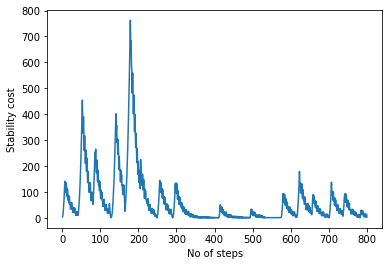

In [17]:
x = range(1, steps+1)   
plt.plot(x, stability_error[10,:])
#plt.fill_between(x, mean_array - std_dev_array, mean_array + std_dev_array, color='blue', alpha=0.2)
plt.xlabel('No of steps')
plt.ylabel('Stability cost')  #between state and predicted state
plt.show()

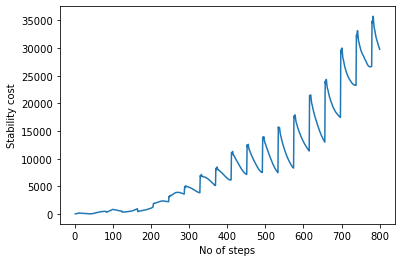

In [16]:
import seaborn as sns

mean_error = []
std = []
for j in range(steps):
    
    mean_error.append(np.mean(stability_error[:,j]))
    std.append(np.std(stability_error[:,j]))
    
mean_array = np.array(mean_error)
std_dev_array = np.array(std)

x = range(1, steps+1)   
plt.plot(x, mean_array)
#plt.fill_between(x, mean_array - std_dev_array, mean_array + std_dev_array, color='blue', alpha=0.2)
plt.xlabel('No of steps')
plt.ylabel('Stability cost')  #between state and predicted state
plt.show()

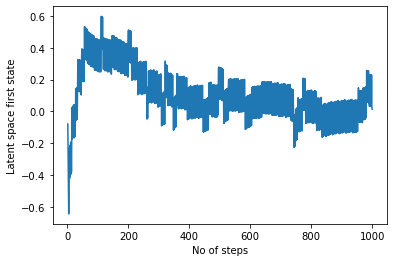

In [59]:

x = range(1, steps+1)   
plt.plot(x, z_value[0,:,0])
#plt.fill_between(x, mean_array - std_dev_array, mean_array + std_dev_array, color='blue', alpha=0.2)
plt.xlabel('No of steps')
plt.ylabel('Latent space first state')  #between state and predicted state
plt.show()


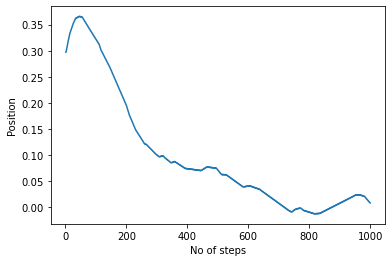

In [60]:
x = range(1, steps+1)   
plt.plot(x, x_value[0,:,0])
#plt.fill_between(x, mean_array - std_dev_array, mean_array + std_dev_array, color='blue', alpha=0.2)
plt.xlabel('No of steps')
plt.ylabel('Position')  #between state and predicted state
plt.show()

In [71]:
#Finding Q value

#import numpy as np
from sklearn.linear_model import LinearRegression

# Example dataset with features x and target y
# Replace with your actual large dataset
x_data = np.concatenate((x_value[0,:,:], x_value[1,:,:],x_value[2,:,:], x_value[3,:,:]),axis=0)  # Feature vectors
#x_data.concat(x_value[1,:,:], x_value[2,:,:])
y_data = np.concatenate((stability_error[0,:], stability_error[1,:],stability_error[2,:], stability_error[3,:]), axis=0)  # Target values
#y_data.concat(y_value[1,:], y_value[2,:])

# Number of dimensions
n = x_data[0].shape[0]

# Step 1: Create matrix A by stacking vec(X_i) for each data point
A = np.vstack([np.outer(x, x).flatten() for x in x_data])

# Step 2: Perform linear regression to solve for vec(Q)
regressor = LinearRegression()
regressor.fit(A, y_data)

# Step 3: Retrieve the coefficients and reshape them into the matrix Q
Q_vec = regressor.coef_
Q_real = Q_vec.reshape((n, n))

# Print the optimized matrix Q
print("Matrix Q:")
print(Q_real)

# Step 4: Use the model to predict y values for the test set (optional)
y_pred = regressor.predict(A)
print("Predicted y values:", y_pred)


Matrix Q:
[[ 3.16360735 -2.10571856 -3.20394826 -1.42029673]
 [-2.10571856  8.03057112 -1.43307054 -8.92119693]
 [-3.20394826 -1.43307054 10.15914423 -1.42342996]
 [-1.42029673 -8.92119693 -1.42342996 -1.10358835]]
Predicted y values: [1.5037741  2.10184765 3.07434649 ... 0.05205589 0.16222712 0.0521769 ]


In [106]:
x_value[:,:,:].shape

(10, 1000, 4)

In [73]:
np.linalg.norm(Psi_o(x_ref,net))

0.007894370854843413

In [30]:
episode = 10
steps = 10
dimension = 4
latent_dimension = 20
starting_states = 10

x_value = np.zeros((starting_states,episode,steps,dimension))
x_pred_value = np.zeros((starting_states,episode,steps,dimension))
z_value = np.zeros((starting_states,episode,steps,latent_dimension))
z_pred_value = np.zeros((starting_states,episode,steps,latent_dimension))

x_error = np.zeros((starting_states,episode,steps,dimension))
z_error = np.zeros((starting_states,episode,steps,latent_dimension))

cum_error = np.zeros((starting_states,episode,steps, dimension))
cum_error_latent = np.zeros((starting_states,episode,steps, latent_dimension))

cum_error_norm = np.zeros((starting_states,episode,steps))
cum_error_norm_latent = np.zeros((starting_states,episode,steps))


u_array = np.zeros((starting_states,episode,steps))

x_ref_lift = Psi_o(x_ref,net)

position_array = np.zeros((starting_states))
angle_array = np.zeros((starting_states))

initial_latent_array = np.zeros((starting_states, latent_dimension))
initial_array = np.zeros((starting_states, dimension))

for k in range(starting_states):
    observation = env.reset()
    
    position_array[k] = observation[0]
    angle_array[k] = observation[2]
    
    x_latent = np.matrix(Psi_o(observation,net))
    initial_latent_array[k, :] = x_latent[Nstates:].reshape(-1)
    
    initial_array[k, :] = observation
    
    
    for i in range(episode):
        
        state = np.array([position_array[k], 0, angle_array[k], 0])                 
        env.reset_for_given_state(state)
        observation = state
            
        #observation = env.reset(reset_state)
        x0 = np.matrix(Psi_o(observation,net))
    
        x_current = net.encode(torch.DoubleTensor(observation))
    
        cumulative_error = np.zeros((dimension))
        cumulative_error_latent = np.zeros((latent_dimension))
        
    
        for j in range(steps):
        
            u = -Kopt*(x0-x_ref_lift)
        
            ureal = net.bilinear_decode_net(torch.DoubleTensor(u)).detach().numpy()
            #define a range for action
            ureal1 = ureal[0,0]
            
            if(ureal[0,0] > umax):
                ureal1 = umax
            elif(ureal[0,0] < umin):
                ureal1 = umin
        
            gu = net.bilinear_net(torch.DoubleTensor(np.array([ureal1]).reshape(-1))).detach().numpy()
    
            next_state = net.forward(x_current,torch.DoubleTensor(gu))
            
            observation, reward, done, info = env.step(ureal1) #real space 
        
            x_value[k,i,j,:] = observation  ##############################        
    
            x0 = next_state.reshape(-1,1).detach().numpy()
            x_current = next_state.reshape(-1)
        
            x_pred_value[k,i,j,:] = x0[:Nstates].reshape(-1) ##########################
            z_value[k,i,j,:] = x0[Nstates:].reshape(-1) ############################
        
            obs_encode = net.encode(torch.DoubleTensor(observation)) #latent + original
            z_pred_value[k,i,j,:] = obs_encode[Nstates:].reshape(-1,1).detach().numpy().reshape(-1)  ############
        
            #error calculate
            x_err = x_value[k,i,j,:] - x_pred_value[k,i,j,:]
            z_err = z_value[k,i,j,:] - z_pred_value[k,i,j,:]
        
            x_error[k,i,j,:] = x_err
            z_error[k,i,j,:] = z_err
            
            #print(x_value[k,i,j,:])
            #print(x_pred_value[k,i,j,:])
        
            #cumulative error
            cumulative_error = cumulative_error + np.abs(x_err)
            cum_error[k,i,j,:] = cumulative_error
            
            cumulative_error_latent = cumulative_error_latent + np.abs(z_err)
            cum_error_latent[k,i,j,:] = cumulative_error_latent
            
            
                  
            observation_list.append(observation.reshape(-1,1))
            u_array[k,i,j]= ureal1
        
                
        
#save variables


        


In [20]:
from scipy.io import savemat

mdic = {"x_val": x_value, "z_val": z_value, "x_pred_val": x_pred_value, "z_pred_val": z_pred_value, "x_error": x_error, "z_error": z_error, 'cum_error': cum_error }
savemat("matlab_planning_error.mat", mdic)

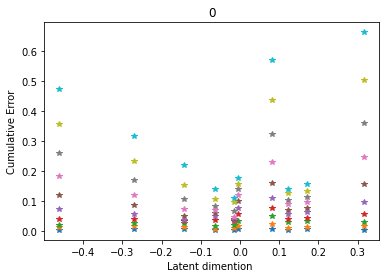

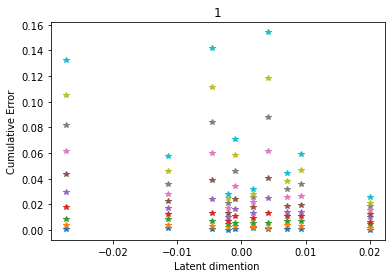

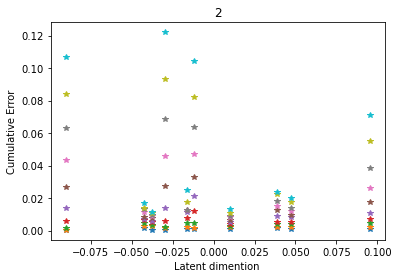

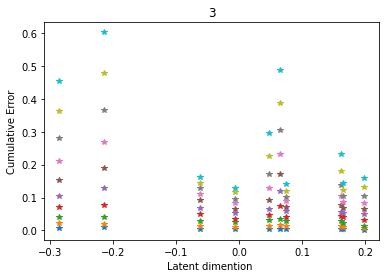

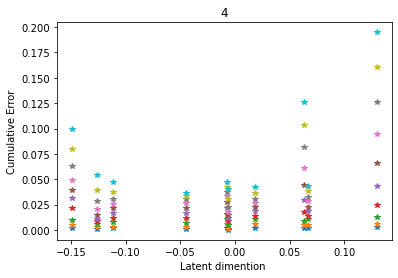

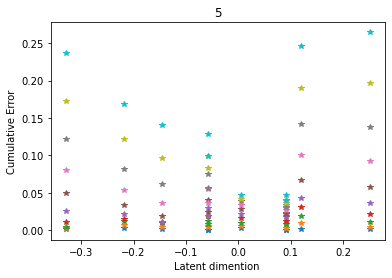

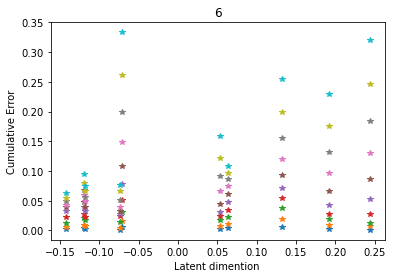

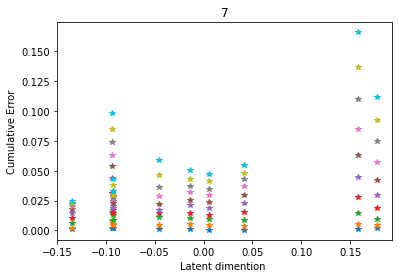

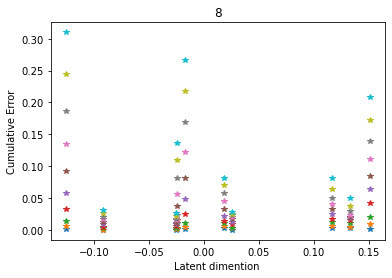

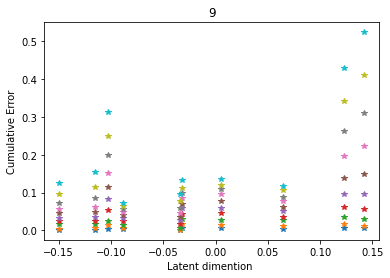

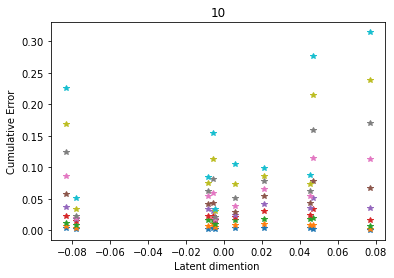

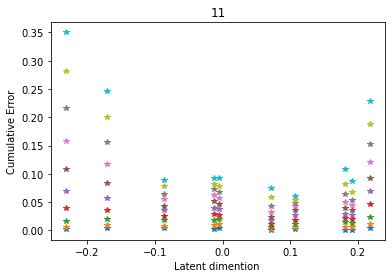

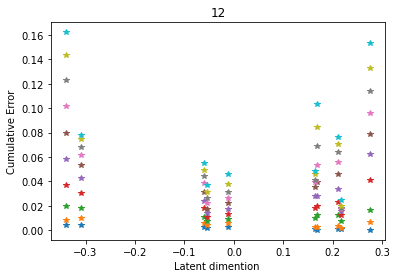

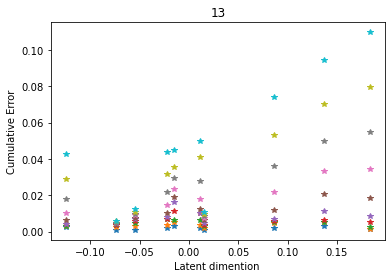

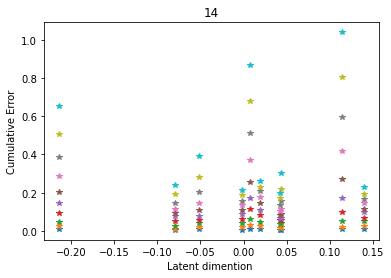

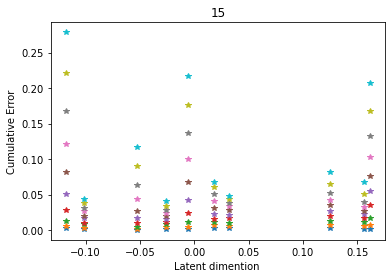

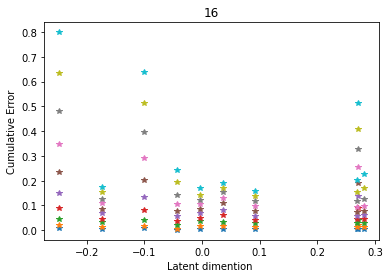

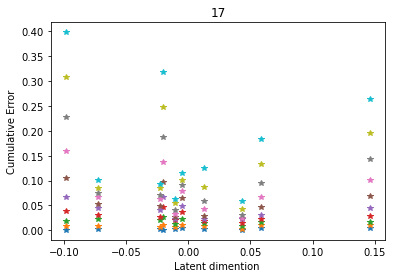

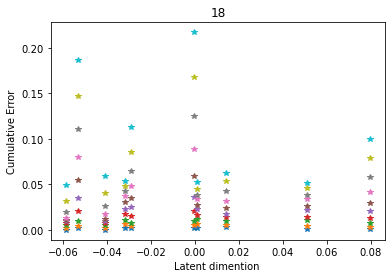

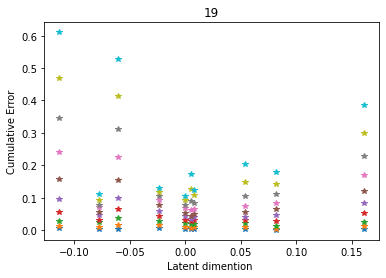

In [29]:
#latent space - Error 


import seaborn as sns


for p in range(latent_dimension):
    x = initial_latent_array[:,p]

    no_steps_results_mean = np.zeros((starting_states,steps)) 

    for i in range(starting_states):
        mean_error = []
        std = []
        for j in range(steps):    
            mean_error.append(np.mean(cum_error_latent[i,:,j,p]))
            std.append(np.std(cum_error_latent[i,:,j,p]))        
            no_steps_results_mean[i,j] = np.mean(cum_error_latent[i,:,j,p])
        
    for l in range(steps):        
        plt.plot(x, no_steps_results_mean[:,l], '*')
        #plt.fill_between(x, mean_array - std_dev_array, mean_array + std_dev_array, color='blue', alpha=0.2)

    plt.xlabel('Latent dimention ')
    plt.ylabel('Cumulative Error')  #between state and predicted state
    plt.title(p)
    plt.show()

In [32]:
x_pred_value[1,0, :,0]

array([-0.20093083, -0.20116384, -0.20375634, -0.20637562, -0.21043988,
       -0.215326  , -0.22131255, -0.22819155, -0.23592701, -0.24471222])

In [23]:
cum_error[8,0,10,0]

292.5387106922651

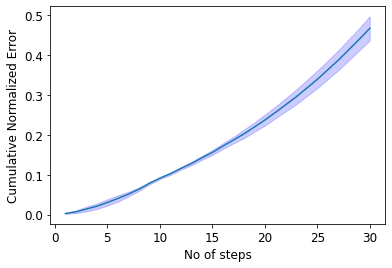

In [57]:
#view error statistics

import seaborn as sns

mean_error = []
std = []
for j in range(steps):
    
    mean_error.append(np.mean(cum_error[:,j]))
    std.append(np.std(cum_error[:,j]))
    
mean_array = np.array(mean_error)
std_dev_array = np.array(std)

x = range(1, 31)   
plt.plot(x, mean_array)
plt.fill_between(x, mean_array - std_dev_array, mean_array + std_dev_array, color='blue', alpha=0.2)
plt.xlabel('No of steps')
plt.ylabel('Cumulative Normalized Error')  #between state and predicted state
plt.show()
    



In [27]:
#state in original space
#find error and then graph

original_error = []
original_error_norm = []
latent_error = []
latent_error_norm = []
latent_err_2 = []
cumulative_error = []
cumu_latent_error = []

state_norm = []
state = []

e1_cum = 0
e2_cum = 0

for j in range(steps-1):
    
    
    e1 = (observation_list[j+1]) - (obs_pred_list[j])
    
    original_error.append(np.abs(e1))
    original_error_norm.append(np.linalg.norm(e1))
    
    e1_cum = np.linalg.norm(e1) + e1_cum
    cumulative_error.append(e1_cum)
    
    e2 = (latent_list[j]) - (latent_x_encode[j].detach().numpy())
    latent_error.append(np.abs(e2))
    latent_error_norm.append(np.linalg.norm(e2))
       
    state.append(observation_list[j+1])
    state_norm.append(np.linalg.norm(observation_list[j+1]))
    
    e2_cum = np.linalg.norm(e2) + e2_cum
    cumu_latent_error.append(e2_cum)
    


NameError: name 'obs_pred_list' is not defined